In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
%matplotlib inline

import os
import shutil
import copy
import random
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import seaborn as sns
import time
from sklearn.metrics import confusion_matrix

from PIL import Image
import matplotlib.pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

Using PyTorch version 1.7.0+cu101
GPU


In [4]:
class_names = ['Non-Covid', 'Covid']
root_dir = '/gdrive/My Drive/Research_Documents_completed/Data/Data/'
source_dirs = ['non', 'covid']

In [5]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png') or x.lower().endswith('jpg')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['Non-Covid', 'Covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

In [6]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(299, 299)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(299, 299)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
train_dirs = {
    'Non-Covid': '/gdrive/My Drive/Research_Documents_completed/Data/Data/non/',
    'Covid': '/gdrive/My Drive/Research_Documents_completed/Data/Data/covid/'
}
train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 3265 Non-Covid examples
Found 203 Covid examples


In [8]:
test_dirs = {
    'Non-Covid': '/gdrive/My Drive/Research_Documents_completed/Data/Data/test/non/',
    'Covid': '/gdrive/My Drive/Research_Documents_completed/Data/Data/test/covid/'
}
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 3000 Non-Covid examples
Found 200 Covid examples


In [9]:
batch_size = 15

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
print(dl_train)
print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 232
Number of test batches 214


In [10]:

class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(25, 15))
    for i, image in enumerate(images):
        plt.subplot(1, 15, i + 1, xticks=[], yticks=[])
        image = image.cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].cpu().numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].cpu().numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

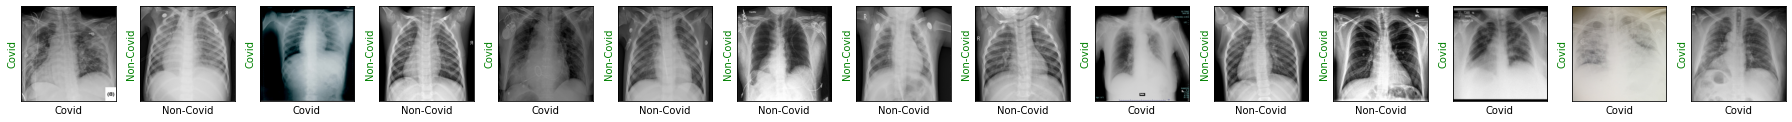

In [11]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

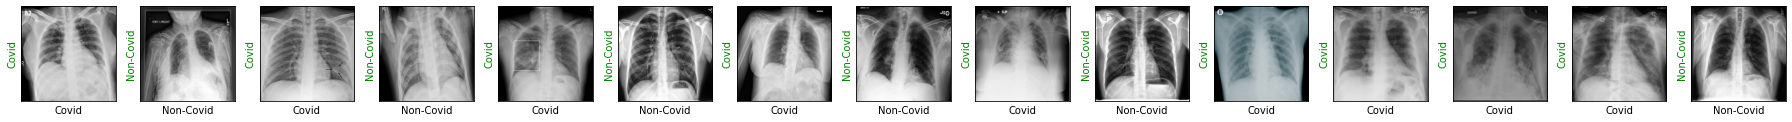

In [12]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

In [13]:
model = torchvision.models.inception_v3(pretrained=True)
model.aux_logits=False
print(model)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth



Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), str

In [14]:
model.fc = torch.nn.Linear(in_features=2048, out_features=2)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
model.to(device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [15]:
def show_preds():
    model.eval()
    images, labels = next(iter(dl_test))
    images = images.to(device)
    outputs = model(images)
    outputs = outputs.to(device)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

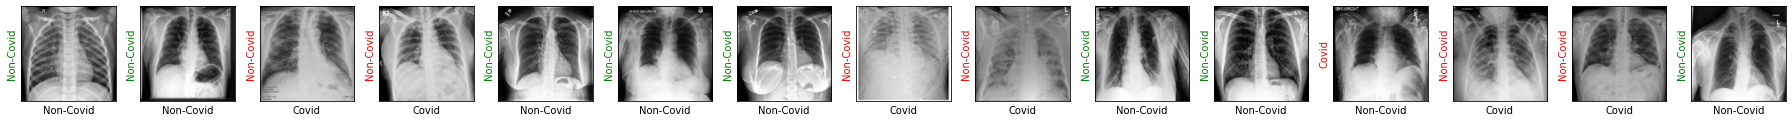

In [16]:
show_preds()

In [17]:
def train(epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    b_acc = 0.0
    t_loss = []
    t_acc = []
    avg_t_loss=[]
    avg_t_acc=[]
    v_loss = []
    v_acc=[]
    avg_v_loss = []
    avg_v_acc = []
    ep = []
    print('Starting training..')
    for e in range(0, epochs):
        ep.append(e+1)
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.
        train_accuracy = 0
        total_train = 0
        correct_train = 0

        model.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            outputs = outputs.to(device)
            _, pred = torch.max(outputs, 1)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_loss /= (train_step + 1)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.nelement()
            correct_train += sum((predicted == labels).cpu().numpy())
            train_accuracy = correct_train / total_train
            t_loss.append(train_loss)
            t_acc.append(train_accuracy)
            
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)
                print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')

                accuracy = 0.  
                model.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    outputs = outputs.to(device)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).cpu().numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.4f}')
                v_loss.append(val_loss)
                v_acc.append(accuracy)
                show_preds()

                model.train()

                if accuracy > b_acc:
                  b_acc = accuracy
                  
                  
        avg_t_loss.append(sum(t_loss)/len(t_loss))
        avg_v_loss.append(sum(v_loss)/len(v_loss))
        avg_t_acc.append(sum(t_acc)/len(t_acc))
        avg_v_acc.append(sum(v_acc)/len(v_acc))
        

    best_model_wts = copy.deepcopy(model.state_dict())
    print('Best validation Accuracy: {:4f}'.format(b_acc))            
    print('Training complete..')
    
    plt.plot(ep, avg_t_loss, 'g', label='Training loss')
    plt.plot(ep, avg_v_loss, 'b', label='validation loss')
    plt.title('Training and Validation loss for each epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('/gdrive/My Drive/Research_Documents_completed/inception_loss.png')
    plt.show()
    
    plt.plot(ep, avg_t_acc, 'g', label='Training accuracy')
    plt.plot(ep, avg_v_acc, 'b', label='validation accuracy')
    plt.title('Training and Validation Accuracy for each epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('/gdrive/My Drive/Research_Documents_completed/inception_accuarcy.png')
    plt.show()
    
    torch.save(model.state_dict(),'/gdrive/My Drive/Research_Documents_completed/inception.pt')        

In [18]:
%%time

train(epochs=5)

Output hidden; open in https://colab.research.google.com to view.

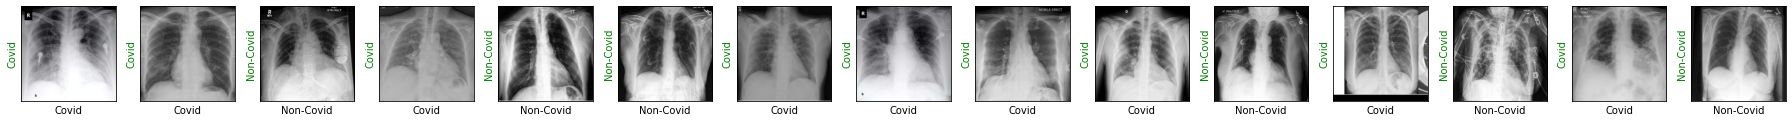

In [19]:
show_preds()